### **本节介绍nadaraya-waston核回归**

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

**1、不带参数的注意力汇聚模型**

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$

**2、带参数的注意力汇聚模型**


$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$

下面实现带参数的注意力汇聚模型

In [22]:
def Test2(**kwargs):
    print(*kwargs)

def Test(**kwargs):
    Test2(**kwargs)

Test(a = 1,b = 2,c = 3)

a b c


In [23]:
x = torch.rand(1)
y = torch.rand((1,))
print(x,x.shape)
print(y,y.shape)

tensor([0.6671]) torch.Size([1])
tensor([0.3809]) torch.Size([1])


**一、模型搭建**

In [24]:
class NWKernelRegression(nn.Module):
    """实现带参数的注意力汇聚模型"""
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad = True))

    def forward(self,queries:torch.Tensor,keys:torch.Tensor,values:torch.Tensor):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)，即(batch_size,pair_size)
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1,keys.shape[1])
        self.attention_weights = nn.functional.softmax(
            -((queries - keys)*self.w)**2 / 2,dim = 1
        )
        # values的形状为(查询个数，“键－值”对个数)，即batch_size
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

**二、数据生成**

In [25]:
# 生成原始数据
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数

print(x_train.shape,y_train.shape,x_test.shape,y_truth.shape)

torch.Size([50]) torch.Size([50]) torch.Size([50]) torch.Size([50])


In [26]:
# 生成训练数据
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
print(keys)
print(x_train)
print(f"keys:{keys.shape},values:{values.shape}")

tensor([[0.2490, 0.4221, 0.5521,  ..., 4.5848, 4.6627, 4.8247],
        [0.1138, 0.4221, 0.5521,  ..., 4.5848, 4.6627, 4.8247],
        [0.1138, 0.2490, 0.5521,  ..., 4.5848, 4.6627, 4.8247],
        ...,
        [0.1138, 0.2490, 0.4221,  ..., 4.5839, 4.6627, 4.8247],
        [0.1138, 0.2490, 0.4221,  ..., 4.5839, 4.5848, 4.8247],
        [0.1138, 0.2490, 0.4221,  ..., 4.5839, 4.5848, 4.6627]])
tensor([0.1138, 0.2490, 0.4221, 0.5521, 0.5680, 0.5773, 0.6867, 0.6904, 0.8125,
        1.0273, 1.0744, 1.1721, 1.1784, 1.2399, 1.2490, 1.3213, 1.3717, 1.3723,
        1.4681, 1.4846, 1.7147, 1.8924, 1.9858, 2.2714, 2.3413, 2.6346, 2.7195,
        2.8305, 2.9244, 2.9384, 3.0815, 3.1142, 3.1419, 3.1775, 3.2472, 3.3060,
        3.3272, 3.3629, 3.3963, 3.4405, 3.9049, 3.9583, 3.9615, 4.0721, 4.1487,
        4.3731, 4.5839, 4.5848, 4.6627, 4.8247])
keys:torch.Size([50, 49]),values:torch.Size([50, 49])


In [27]:
a = x_train.repeat_interleave(keys.shape[1]).reshape(-1,keys.shape[1])
print(a,a.shape)
b = a.reshape(-1,keys.shape[1])
print(b,b.shape)

tensor([[0.1138, 0.1138, 0.1138,  ..., 0.1138, 0.1138, 0.1138],
        [0.2490, 0.2490, 0.2490,  ..., 0.2490, 0.2490, 0.2490],
        [0.4221, 0.4221, 0.4221,  ..., 0.4221, 0.4221, 0.4221],
        ...,
        [4.5848, 4.5848, 4.5848,  ..., 4.5848, 4.5848, 4.5848],
        [4.6627, 4.6627, 4.6627,  ..., 4.6627, 4.6627, 4.6627],
        [4.8247, 4.8247, 4.8247,  ..., 4.8247, 4.8247, 4.8247]]) torch.Size([50, 49])
tensor([[0.1138, 0.1138, 0.1138,  ..., 0.1138, 0.1138, 0.1138],
        [0.2490, 0.2490, 0.2490,  ..., 0.2490, 0.2490, 0.2490],
        [0.4221, 0.4221, 0.4221,  ..., 0.4221, 0.4221, 0.4221],
        ...,
        [4.5848, 4.5848, 4.5848,  ..., 4.5848, 4.5848, 4.5848],
        [4.6627, 4.6627, 4.6627,  ..., 4.6627, 4.6627, 4.6627],
        [4.8247, 4.8247, 4.8247,  ..., 4.8247, 4.8247, 4.8247]]) torch.Size([50, 49])


In [28]:
net = NWKernelRegression()
output = net(x_train,keys,values)
print(output.shape)

torch.Size([50])


In [29]:
x = torch.rand((1,3),requires_grad = True)
print(type(x),type((x.detach().numpy())))

<class 'torch.Tensor'> <class 'numpy.ndarray'>


**三、模型训练**

In [30]:
def train(net,nums_epoch = 100):
    loss = nn.MSELoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=0.5)
    net.train()
    from tqdm import tqdm
    loop = tqdm(range(nums_epoch),total = nums_epoch)
    for i in loop:
        trainer.zero_grad()
        y_pred = net(x_train,keys,values)
        l = loss(y_pred,y_train)
        l.sum().backward()
        trainer.step()
        loop.set_description(f'Epoch [{i + 1}/{nums_epoch}]')
        loop.set_postfix({"LOSS" : l.sum().item(),"lr" : "{:e}".format(0.5)})

In [31]:
train(net)

Epoch [100/100]: 100%|██████████| 100/100 [00:00<00:00, 640.22it/s, LOSS=12, lr=5.000000e-01]


In [32]:
net.eval()
output = net(x_test,keys,values)

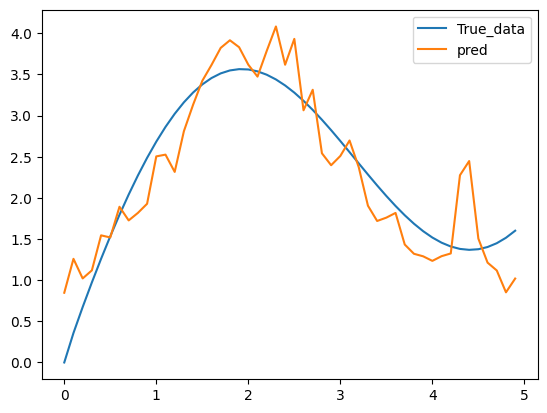

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# plt.plot(np.arange(len(x_train.numpy())),y_train.numpy(),label = 'label')
# plt.plot(np.arange(len(x_train.numpy())),output.detach().numpy(),label = 'pred')
# plt.legend()
# plt.show()
# plt.plot(x_train.numpy(),y_train.numpy())
plt.plot(x_test,y_truth,label = 'True_data')
plt.plot(x_test,output.detach().numpy(),label = 'pred')
plt.legend()
plt.show()